In [1]:
# Import statements
import time
import datetime
import json
import math
import ast
import os
import csv
import sys
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import our own CDC analysis package
import cdc_analysis_methods

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Magic
% matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Gathering Data

## Actual Death Data

We will compare news and Google Trends data with the actual numbers of how many people die from specific causes of death. A dataset encompassing every death that occurred in the US since 1999 is available at https://wonder.cdc.gov/. A dataset that summarizes the number of people who died from causes as specified in the International Catalogue of Diseases (ICD-10) is saved in data/cdc_by_year_and_icd10_cause_1999_2016.txt.

### Define death cause categories

We will now define death cause categories of interest and gather the numbers for these categories from the CDC dataset. The categories are defined by a name (dictionary keys) and ranges of ICD-10 blocks. The information that was used to define these categories comes mostly from looking up ICD-10 diagnoses on Wikipedia and other online resources.

In [2]:
cat_codename_icd_dict = {'heart':           ['I05-I09',
                                             'I11',
                                             'I20-I25',
                                             'I26-I28',
                                             'I30-I52'],
                        'cancer_all':       ['C00-D48'],
                        'cancer_lung':      ['C34'],
                        'cancer_anal':      ['C13-C21'],
                        'cancer_breast':    ['C50'],
                        'loresp':           ['J40-J47'],
                        'accident':         ['V01-X59'],
                        'stroke':           ['I61-I64'],
                        'alzheimer':        ['F00',
                                             'G30'],
                        'diabetes':         ['E10-E14'],
                        'influpneu':        ['J09-J18'],
                        'kidney':           ['N00-N29'],
                        'suicide':          ['X60-X84'],
                        'homicide_all':     ['X85-Y09'],
                        'homicide_firearm': ['X93-X95'],
                        'homicide_legmil':  ['Y35-Y36'],
                        'overdose':         ['X40-X49'],
                        'terrorism':        ['U01']}

### Build a function that returns death numbers per category

Next, we define a function that understands these ICD-10 block ranges. The function takes a ICD-10 block range string (such as 'I05-I09') and returns a list of all ICD-10 blocks that are within the specified range and also occur at least once in the CDC dataset. For better readability, the function is outsourced to cdc_analysis_methods.py. Let's see what it does:

In [3]:
cdc_analysis_methods.get_cdc_icd_blocks('I05-I09')

array(['I05', 'I06', 'I07', 'I08', 'I09'], dtype=object)

In [4]:
cdc_analysis_methods.get_cdc_icd_blocks('V90-W09')

array(['V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98',
       'V99', 'W00', 'W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07',
       'W08', 'W09'], dtype=object)

The next step is to define a method that returns the number of people who died from a cause that falls within a specified ICD-10 block range. The method also takes years to consider (the default is 'all', which scrapes data from all available years 1999-2016). The first number that is returned is the absolute number of people, the second number is the first number divided by the population of the US in that year (which is specified in the CDC dataset, as well)

In [5]:
cdc_analysis_methods.get_mortality_by_icd_block_range('I05-I10', years=2002)

[15184.0, 5.2790925028601367e-05]

Based on this method, we can now build another method that takes in the dictionary of death cause categories that we defined above and that returns the number of people who died from a cause that falls within any of these categories. Again, the function is in the cdc_analysis_methods package, it optionally takes years, returns the normalized mortality, and it looks like this:

In [6]:
cdc_analysis_methods.get_mortality_by_category(cat_codename_icd_dict, years='all')

,raw_mortality,rel_mortality
heart,11512237.0,0.038297
cancer_all,10504850.0,0.034816
cancer_lung,2817213.0,0.009349
cancer_anal,1483182.0,0.004924
cancer_breast,747919.0,0.002482
loresp,2434726.0,0.008051
accident,2146673.0,0.007084
stroke,1988802.0,0.006628
alzheimer,1373412.0,0.004509
diabetes,1316379.0,0.004362


### Validate results

We have now defined our categories and are able to gather the related data from CDC. Time to see if our data processing pipeline is valid. We check that by comparing our results with summarized data available on the Internet:

In [7]:
def compare_top_causes_2016(our_data_df):
    # Comparison data
    comp_top10 = pd.read_csv('./data/medicalnewstoday_statista_top_deaths_2016.csv')
    comp_top10 = comp_top10.set_index('cause')
    comp_top10[comp_top10 == 0] = None

    # Data for normalization, extracted from cdc:
    pop_2016      = 318810586
    n_deaths_2016 = 2744248

    # Normalize data by number of deaths in 2016
    comp_top10['mnt_ratio'] = comp_top10['mnt_deaths']/n_deaths_2016
    comp_top10['statista_ratio'] = comp_top10['statista_deaths']/n_deaths_2016
    comp_top10['cdc_ratio'] = our_data_df['raw_mortality']/n_deaths_2016

    comp_top10.loc[:, ['cdc_ratio', 'mnt_ratio', 'statista_ratio']].plot.bar()


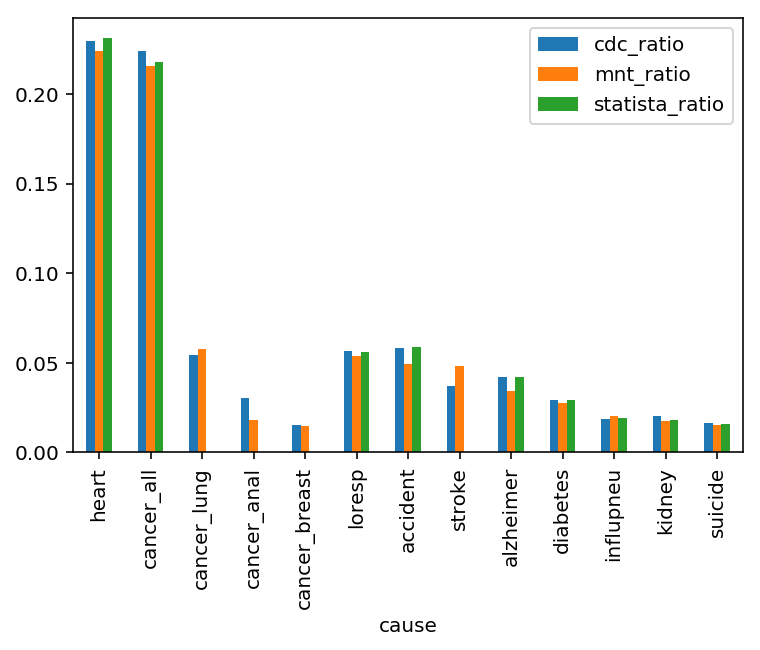

In [8]:
# Our data
cdc_data_2016 = cdc_analysis_methods.get_mortality_by_category(cat_codename_icd_dict, years=2016)

compare_top_causes_2016(cdc_data_2016)

That looks overall very decent. The small fluctuations in the numbers by information source are within a reasonable range. We can go on!

## Newspaper Mentions

We'd like to see how often our different causes of death are mentioned in the news. Both the New York Times and the Guardian provide helpful APIs that allow us to query their database for how often a word is mentioned. Using the code below, we can load up our API keys to allow us make the appropriate function calls.

In [14]:
# Importing API key
nytAPIPath = 'nytDevKey.txt'
fin=open(nytAPIPath,'r')
nyt_api_key = str(fin.readline()).rstrip()

guardianAPIPath = 'guardianAPI.txt'
fin=open(guardianAPIPath,'r')
guardian_api_key = str(fin.readline()).rstrip()

FileNotFoundError: [Errno 2] No such file or directory: 'nytDevKey.txt'

Now that we've got our API keys set, we'll write two functions which can search both the NYT and the Guardian's databases. We'll use Requests to make the HTTP request and parse the resulting JSON to grab the number of hits, which is either denoted as 'hits' or as 'total'.

In [ ]:
# NYT API:
nyt_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json";

def searchNYT(string, startDate, endDate, page="0", justHits=False):
    searchString = (nyt_url + '?fq=' + '"' + string + '"' + '&page=' + page 
                    + '&begin_date=' + startDate + '&end_date=' + endDate + '&api-key=' + nyt_api_key)
    
    response = requests.get(searchString).json();

    if (justHits):
        
        # logic to handle different response types, standardizes them
        if 'response' not in response.keys():
            response = ast.literal_eval(response['message'])
    
        return response['response']['meta']['hits']
    
    else:
        return response
    
        
# The Guardian's API
guardian_url = "https://content.guardianapis.com/search"

def searchGuardian(string, startDate, page='1', justHits=False):
    searchString = (guardian_url + '?q=' + '"' + string + '"' + '&from-date=' + startDate + 
                    '&page=' + page + '&page-size=50' + '&order-by=oldest' + 
                    '&api-key=' + guardian_api_key)
    
    response = requests.get(searchString);
    
    response = response.json()
    
    if (justHits):
        return response['response']['total']
    else:
        return response

In order to do our search, we'll load in our CSV of all our keywords:

In [ ]:
wordsList = pd.read_csv('./keywords.csv')

Now we'll go through our list of keywords and record their counts and save it as a CSV for both the NYT and the Guardian. (Note that because this takes quite a while, we've just shown some of the output and not all of it, but you can see that the code is indeed designed to iterate over all years.)

### Scraping The New York Times

In [ ]:
try:
    for year in range(1999, 2017):
        tempList = []

        for j in range(len(wordsList)):
            time.sleep(0.7)
            tempList.append(searchNYT(wordsList.iloc[j][0], str(year)+"-01-01", str(year+1)+"-01-01", justHits=True))
            print(tempList[j], end=' ')

        # np.savetxt(str(year) + '.csv', tempList)

        print("Done!")
        
except KeyboardInterrupt:
    sys.exit(0)

### Scraping The Guardian

In [ ]:
try:
    for year in range(1999, 2017):
        tempList = []

        for j in range(len(wordsList)):

            time.sleep(0.1)

            diff1 = (searchGuardian(wordsList.iloc[j][0], str(year)+"-01-01", justHits=True))

            time.sleep(0.1)

            diff2 = (searchGuardian(wordsList.iloc[j][0], str(year+1)+"-01-01", justHits=True))

            # The Guardian's hits number is the number from that the past to the time specified, so we must make two calls
            # and take the difference to get an accurate number.
            
            diff = diff1 - diff2
            
            tempList.append(diff)

            print(diff, end=' ')

        np.savetxt('./results/' + str(year) + '.csv', tempList)

        print('Done!')
        
except KeyboardInterrupt:
    sys.exit(0)

## Google Trends

For Google Trends, there is an API called pytrends that makes queries to Google for us and returns data from 2004 onwards about the relative search frequencies of different terms.

In [ ]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

It makes less sense, though, to aggregate search results for related words, especially as Google Trends data might not be necessarily additive. So instead we'll import our "main list" of the general categories we care about:

In [ ]:
majorKeywords = pd.read_csv('./majorKeywords.csv')

In [ ]:
majorKeywords

Now we'll run pytrends and get back a new dataframe that includes the counts, month-by-month, of our data. (Note that below, we've slightly modified the names of the majorKeywords to allow us better search coverage.)

In [ ]:
googleTrendSum = pd.DataFrame();

majorWords = ['heart disease', 'cancer', 'respiratory disease', 'car accidents', 'stroke', 'diabetes', 
              'alzheimer\'s', 'pneumonia', 'kidney disease', 'suicide', 'homicide', 'terrorism', 'overdose']

for i in majorWords:
    kw_list = []
    kw_list.append(i)
    pytrends.build_payload(kw_list, cat=0, 
                       timeframe='all', geo='', gprop='')
    df = pytrends.interest_over_time()[i]
    googleTrendSum[i] = df

Here is a preview of our data:

In [ ]:
googleTrendSum = googleTrendSum.transpose()

In [ ]:
googleTrendSum.iloc[:, 0:5]

## Cleaning The Data

### NYT and Guardian

We need to modify our NYT and Guardian hit list to make sure it conforms to our majorKeywords list. Let's load up their CSVs first and see what they look like:

In [ ]:
nyt_final = pd.read_csv('./results/NYT/nyt_counts.csv').drop(['Unnamed: 0'], axis=1)
guardian_final = pd.read_csv('./results/Guardian/guardian_counts.csv').drop(['Unnamed: 0'], axis=1)

In [ ]:
nyt_final

In [ ]:
guardian_final

Okay, so there are a lot more categories here than we care about. So let's merge the related ones into our majorKeywords list so we can start to do some better comparisons.

In [ ]:
nyt_total = pd.DataFrame()

nyt_total['Heart Disease'] = nyt_final.iloc[0:3, 1:].sum()
nyt_total['Cancer'] = nyt_final.iloc[3:5, 1:].sum()
nyt_total['Lower Respiratory Disease'] = nyt_final.iloc[5:9, 1:].sum()
nyt_total['Car Accidents'] = nyt_final.iloc[10:13, 1:].sum()
nyt_total['Stroke'] = nyt_final.iloc[13:15, 1:].sum()
nyt_total['Alzheimer\'s Disease'] = nyt_final.iloc[15:16, 1:].sum()
nyt_total['Diabetes'] = nyt_final.iloc[16:17, 1:].sum()
nyt_total['Pneumonia & Influenza'] = nyt_final.iloc[17:20, 1:].sum()
nyt_total['Kidney'] = nyt_final.iloc[20:24, 1:].sum()
nyt_total['Suicide'] = nyt_final.iloc[24:26, 1:].sum()
nyt_total['Homicide'] = nyt_final.iloc[26:30, 1:].sum()
nyt_total['Terrorism'] = nyt_final.iloc[30:33, 1:].sum() + nyt_final.iloc[33:35, 1:].sum() 
nyt_total['Overdose'] = nyt_final.iloc[38:39, 1:].sum()

nyt_total = nyt_total.transpose()

guardian_total = pd.DataFrame()

guardian_total['Heart Disease'] = guardian_final.iloc[0:3, 1:].sum()
guardian_total['Cancer'] = guardian_final.iloc[3:5, 1:].sum()
guardian_total['Lower Respiratory Disease'] = guardian_final.iloc[5:9, 1:].sum()
guardian_total['Car Accidents'] = guardian_final.iloc[10:13, 1:].sum()
guardian_total['Stroke'] = guardian_final.iloc[13:15, 1:].sum()
guardian_total['Alzheimer\'s Disease'] = guardian_final.iloc[15:16, 1:].sum()
guardian_total['Diabetes'] = guardian_final.iloc[16:17, 1:].sum()
guardian_total['Pneumonia & Influenza'] = guardian_final.iloc[17:20, 1:].sum()
guardian_total['Kidney'] = guardian_final.iloc[20:24, 1:].sum()
guardian_total['Suicide'] = guardian_final.iloc[24:26, 1:].sum()
guardian_total['Homicide'] = guardian_final.iloc[26:30, 1:].sum()
guardian_total['Terrorism'] = guardian_final.iloc[30:33, 1:].sum() + guardian_final.iloc[33:35, 1:].sum()
guardian_total['Overdose'] = guardian_final.iloc[38:39, 1:].sum()

guardian_total = guardian_total.transpose()

In [ ]:
nyt_total

In [ ]:
guardian_total

Now the two dataframes are looking a lot cleaner! Our last step is to normalize them across each year, so we don't need to worry about problems with increased traffic over time, and this makes it easier to graph.

In [ ]:
nyt_sums = nyt_total.iloc[:, 0:].sum()
guardian_sums = guardian_total.iloc[:, 0:].sum()

In [ ]:
nyt_total.divide(nyt_sums)

In [ ]:
guardian_total.divide(guardian_sums)

In [ ]:
guardian_total

### Google Trends

First off, we need to group up our data by years, as the raw Google trends data is month by month.

In [ ]:
newGoogle = pd.DataFrame()
for i in range(0,13):
    newGoogle[str(i+2004)] = googleTrendSum.iloc[:, (i*12):(i+1)*12].sum(axis=1)

Now our data looks like this:

In [ ]:
newGoogle

Looking good! Once more, we just normalize, and then we are done:

In [ ]:
google_totals = newGoogle.iloc[:, :].sum()

In [ ]:
newGoogle.divide(google_totals)